In [2]:
# Set Base Parameters
# Increase processing demands if on Colab
BASE_EPOCHS = 3
BATCH_SIZE = 512
BASE_PATIENCE = 5
MIN_DELTA = .02
MONITOR = "val_accuracy"
LOGS = "logs"
DIR_OUT = "kt_out"
PROJECT = "kt_basics"
FACTOR = 3
VALIDATION = .2
MAX_TRIALS = 3

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
  BASE_EPOCHS = 5
  BATCH_SIZE = 1024
  BASE_PATIENCE =3
  MAX_TRIALS = 5
  !pip install keras_tuner

import numpy as np
import pandas as pd
import tensorflow as tf
import keras_tuner as kt
import matplotlib.pyplot as plt
import keras
from tensorflow import keras
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Input, Normalization, BatchNormalization
from keras import layers
import sklearn
import datetime

from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.utils import to_categorical
import itertools
import io


In [3]:
# Helper to plot loss
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.legend()
  plt.grid(True)
  plt.show()

def plot_acc(history):
  plt.plot(history.history['accuracy'], label='accuracy')
  plt.plot(history.history['val_accuracy'], label='val_accuracy')
  plt.legend()
  plt.grid(True)
  plt.show()

In [4]:
def plot_to_image(figure):
  """Converts the matplotlib plot specified by 'figure' to a PNG image and
  returns it. The supplied figure is closed and inaccessible after this call."""
  # Save the plot to a PNG in memory.
  buf = io.BytesIO()
  plt.savefig(buf, format='png')
  # Closing the figure prevents it from being displayed directly inside
  # the notebook.
  plt.close(figure)
  buf.seek(0)
  # Convert PNG buffer to TF image
  image = tf.image.decode_png(buf.getvalue(), channels=4)
  # Add the batch dimension
  image = tf.expand_dims(image, 0)
  return image

def image_grid():
  """Return a 5x5 grid of the MNIST images as a matplotlib figure."""
  # Create a figure to contain the plot.
  figure = plt.figure(figsize=(10,10))
  for i in range(25):
    # Start next subplot.
    plt.subplot(5, 5, i + 1, title=class_names[train_labels[i]])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)

  return figure
def plot_confusion_matrix(cm, class_names):
  """
  Returns a matplotlib figure containing the plotted confusion matrix.

  Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
  """
  figure = plt.figure(figsize=(8, 8))
  plt.imshow(cm, interpolation='nearest', cmap="binary")
  plt.title("Confusion matrix")
  plt.colorbar()
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names, rotation=45)
  plt.yticks(tick_marks, class_names)

  # Compute the labels from the normalized confusion matrix.
  labels = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

  # Use white text if squares are dark; otherwise black.
  threshold = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    color = "white" if cm[i, j] > threshold else "black"
    plt.text(j, i, labels[i, j], horizontalalignment="center", color=color)

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  return figure

def log_confusion_matrix(epoch, logs):
  # Use the model to predict the values from the validation dataset.
  test_pred_raw = model.predict(test_images)
  test_pred = np.argmax(test_pred_raw, axis=1)

  # Calculate the confusion matrix.
  cm = sklearn.metrics.confusion_matrix(test_labels, test_pred)
  # Log the confusion matrix as an image summary.
  figure = plot_confusion_matrix(cm, class_names=class_names)
  cm_image = plot_to_image(figure)

  # Log the confusion matrix as an image summary.
  with file_writer_cm.as_default():
    tf.summary.image("epoch_confusion_matrix", cm_image, step=epoch)

# Define the per-epoch callback.


NameError: name 'logdir' is not defined

# Keras Tuner

We can use the Keras Tuner to find the best hyperparameters for our model, in a similar way to how we usd a grid search to find the best hyperparameters for our scikit-learn models. The process is a little more involved, but it's still pretty straightforward. 

### Logs and Records

All of the stuff we are looking at here relies on log and record files being saved to disk. We can save them anywhere, but it is probably a good idea to consolidate them in some organized way. We can do this by creating a new directory called `logs` in the root of our project, and putting the log results in there. One thing to watch out for is that you can sometimes get odd errors or warnings if you are looking at the log files for some other model. This is because it is expecting to find things that it has written for the model to which it belongs. This is very annoying, ask me how I know. For real applications, youd probably want to make specific folders to track these things - for our repeated trials, I have added a little datetime stamp to some file names to just ensure that they are unique.

In [10]:
### Parameters

# Metrics
acc = keras.metrics.CategoricalAccuracy(name="accuracy")
pre = keras.metrics.Precision(name="precision")
rec = keras.metrics.Recall(name="recall")
metric_list = [acc, pre, rec]


# Callbacks
file_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, mode="max")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=LOGS+"/tb/"+file_time, histogram_freq=1, write_images=True, embeddings_freq=1, update_freq='epoch')

#### Load Data

We will start with using the fashion dataset. 

In [ ]:
# Load Data
(img_train, label_train), (img_test, label_test) = keras.datasets.fashion_mnist.load_data()
print(img_train.shape, label_train.shape, img_test.shape, label_test.shape)

images = np.concatenate([img_train, img_test], axis=0)
labels = np.concatenate([label_train, label_test], axis=0)
test_images = images[-25:]
test_labels = labels[-25:]
print(images.shape, labels.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)
(70000, 28, 28) (70000,)


## Model Builder

To use Keras Tuner, you need to define a model builder function. This function takes a hyperparameter dictionary as input and returns a compiled model. In plain language, the model builder function is basically a framework for creating a model, with the key difference that we set things up so that the hyperparameters that we are testing are variables in the model construction. 

### HP.whatever

The hyperparameters that we are testing are defined using the HP.[Type_of_choice] functions. For example, HP.Choice defines a hyperparameter that can take on one of a list of values. HP.Float defines a hyperparameter that can take on any value between a minimum and maximum value. HP.Int defines a hyperparameter that can take on any integer value between a minimum and maximum value. Each thing that we want to change in the search is set up with one of these "hp." functions, along with the range of values we want to test.

When the hyperparameter search is called, these hyperparameters will be varied according to the search algorithm that we choose - just as a grid search would work through the various combinations of hyperparameters in the list we supply. We can build this model builder function to test almost anything we can think of - different number of neurons, different number of layers, different types of layers, different activation functions, different optimizers, different learning rates, etc... The possibilities of what we can test are really only limited by our imagination and the time it takes to run the search. Some key hp items to be aware of are:
<ul>
<li>HP.Choice - a hyperparameter that can take on one of a list of values</li>
<li>HP.Float - a hyperparameter that can take on any value between a minimum and maximum value</li>
<li>HP.Int - a hyperparameter that can take on any integer value between a minimum and maximum value</li>
</ul>

In [64]:
def model_builder2(hp):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(28, 28)))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model.add(keras.layers.Dense(units=hp_units, activation='relu'))
  # Layer 2
  hp_units2 = hp.Int('units2', min_value=32, max_value=512, step=32)
  model.add(keras.layers.Dense(units=hp_units2, activation='relu'))
  
  model.add(keras.layers.Dense(10))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model

## Hypertuning

Our model builder is the core of the hyperparameter tuning process, using it is relatively simple. We use the model builder as an input to the type of parameter search we want to do, there are a few options offered in the keras tuner:
<ul>
<li> Grid search - searches over a grid of hyperparameters like we are used to. </li>
<li> Random search - randomly selects hyperparameters from the search space and trains a model for each combination. </li>
<li> Hyperband - a more advanced search algorithm that uses early stopping to quickly identify high-performing models. This is a good option when you have a large search space and want to run a quick search. (The factor represents a ratio that the algorithm reduces the number of models trained from trial to trial, lower values leave more models)</li>
<li> Bayesian optimization - uses Bayesian optimization to identify high-performing hyperparameter values. Specifically, it starts by randomly selecting things, then uses performance to be smart about which others to select. </li>
</ul>

Once we've setup the search, we call the search() function in a very similar way to the fit() function. The search() function will run the search and find the best set of hyperparameters for our model. The Baeysian or Hyperband will likely perform much more quickly, especially as the seach space expands. 

In [65]:
tuner = kt.Hyperband(hypermodel = model_builder2,
                     objective=MONITOR,
                     max_epochs=BASE_EPOCHS,
                     factor=3,
                     directory=DIR_OUT,
                     project_name=PROJECT,
                     overwrite=True)

/Users/akeem/anaconda3/envs/blank_tf/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Get Results

We can get the results of the trial, just like in a grid seach. One note on getting the best models or parameters down below is that we can get more than one. Below we are only grabbing the best model and hyperparameters, but we could get the top 3 or however many we wanted. 

In [66]:
# Get Results
tuner.search(img_train, label_train, epochs=BASE_EPOCHS, validation_split=VALIDATION, callbacks=[stopping])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')}, the second is {best_hps.get('units2')}, and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 6 Complete [00h 00m 44s]
val_accuracy: 0.4739166796207428

Best val_accuracy So Far: 0.8325833082199097
Total elapsed time: 00h 02m 47s

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 224, the second is 96, and the optimal learning rate for the optimizer
is 0.001.



## Train the Best Model

Once we have the best parameters, we can train a final model. Here I'll train a model on ALL of the data, since we already know the best parameter, this is the model that we think will do the best job and will be the one we can use in production.

In [67]:
# Build the model with the optimal hyperparameters and train it on the data
model = tuner.hypermodel.build(best_hps)
history = model.fit(images, labels, epochs=BASE_EPOCHS, validation_split=VALIDATION)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/3
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.7124 - loss: 6.0985 - val_accuracy: 0.7753 - val_loss: 0.7165
Epoch 2/3
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.8093 - loss: 0.5758 - val_accuracy: 0.8274 - val_loss: 0.5202
Epoch 3/3
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.8312 - loss: 0.4866 - val_accuracy: 0.8367 - val_loss: 0.4817
Best epoch: 3


#### Results

We can use this tuning approach to get a good fitting model without as much manual work in running trials. We can also likely repurpose parts of the model builder code, since things like testing layer sizes, number of layers, or activation functions are likely to be useful in other models and are exactly the same, no matter the specific model. 

The primary downside to running a search like this is that it is computationally expensive and potentially very slow to execute. When applying this to larger datasets we likely want to:
<ul>
<li> Use a GPU/cloud to speed up the training process. </li>
<li> Use a sample of the data to speed up the process, or use a sample to find which types of hyperparameter choices are worthy of a larger test.</li>
<li> Reduce number of epochs. </li>
<li> Start with larger jumps, then narrow down on what is working. </li>
</ul>

The idea of the Keras tuning process is pretty simple, and the same as the grid search - we want to find the optimal set of hyperparameters and layer configuration for the model. The Keras Tuner makes this process much easier, and allows us to test a much larger number of combinations than we could manually, however we are much more likely to hit a limit of how many trials we can run due to time, so starting with an educated guess is still beneficial. 

## Larger Example

We can make our model even more complex and flexible. As long as we are able to define the options with ifs and loops, we can probably try almost anything we can think of. We can try a CNN version here:

In [68]:
# Note: the class names are taken from the documentation
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()
X_train, X_test = X_train / 255.0, X_test / 255.0
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
y_test = to_categorical(y_test)
y_train = to_categorical(y_train)

In [69]:
def build_model4(hp):
    model = keras.Sequential()
    model.add(layers.Input(shape=(32, 32, 3)))
    model.add(layers.Conv2D(64, (3, 3), activation='leaky_relu', padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    for i in range(hp.Int("num_layers", 2, 3)):
        model.add(layers.Conv2D(hp.Int("filters_L"+str(i), min_value=128, max_value=512, step=128), (3, 3), activation='relu', padding="same"))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(Flatten())
    model.add(layers.Dense(1024, activation="relu", kernel_regularizer="l2"))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(512, activation="relu", kernel_regularizer="l2"))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(10, activation="softmax"))
    
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [70]:
file_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tuner3 = kt.BayesianOptimization(build_model4,
                        objective=MONITOR,
                        max_trials=MAX_TRIALS,
                        directory=DIR_OUT+"/"+file_time,
                        project_name=PROJECT,
                        overwrite=True)

In [71]:
# Run Search
tuner3.search(X_train, y_train, epochs=BASE_EPOCHS, validation_split=VALIDATION, callbacks=[stopping], batch_size=BATCH_SIZE)

# Get the optimal hyperparameters
best_hps3 = tuner3.get_best_hyperparameters(num_trials=1)[0]
best_model3 = tuner3.get_best_models(num_models=1)[0]
best_model3.build(input_shape=(None, 32, 32, 3))
best_model3.summary()

Trial 5 Complete [00h 01m 34s]
val_accuracy: 0.15219999849796295

Best val_accuracy So Far: 0.19259999692440033
Total elapsed time: 00h 09m 06s

Search: Running Trial #6

Value             |Best Value So Far |Hyperparameter
2                 |2                 |num_layers
256               |256               |filters_L0
512               |128               |filters_L1
384               |None              |filters_L2

Epoch 1/3
79/79 ━━━━━━━━━━━━━━━━━━━━ 51s 583ms/step - accuracy: 0.4529 - loss: 18.8167 - val_accuracy: 0.1075 - val_loss: 5.8682
Epoch 2/3
79/79 ━━━━━━━━━━━━━━━━━━━━ 42s 529ms/step - accuracy: 0.6642 - loss: 2.8017 - val_accuracy: 0.0997 - val_loss: 5.2923
Epoch 3/3
52/79 ━━━━━━━━━━━━━━━━━━━━ 14s 535ms/step - accuracy: 0.7300 - loss: 1.6469

KeyboardInterrupt: 

## Monitoring Training with Tensorboard

We can use the tensorboard to monitor our training as we progess. 

<b>Note:</b> if you run this in VS Code, the behavior will be different. It will likely ask you to install a plugin. On Colab, it'll appear beneath the code. 

In [5]:
# Sets up a timestamped log directory.
!rm -rf logs/tb/*
!rm -rf logs/tb/cm/*
logdir = "logs/tb" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
file_writer_cm = tf.summary.create_file_writer(logdir + '/cm')
# Creates a file writer for the log directory.
file_writer = tf.summary.create_file_writer(logdir)
cm_callback = keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)

2024-04-09 13:45:32.290991: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-04-09 13:45:32.291033: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2024-04-09 13:45:32.291049: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2024-04-09 13:45:32.291075: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-09 13:45:32.291094: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
%load_ext tensorboard
%tensorboard --logdir=logs/tb


### Checkpoints 

We can also use checkpoints to save the best model as we go, this is a good way to make sure we don't lose our best model if we have to stop the training process early. This is also a good way to make sure we don't have to retrain the model if we have to restart the notebook.

#### Checkpoint Callback

We can build the checkpoint saving process into our model training fairly easily, by putting it into a callback. This callback is a lot like the early stopping one, but instead it just saves the weights of the model whenever it sees an improvement. If the next epoch is better, we save the updated model, if it is worse, we do nothing. On subsequent runs, we can load the weights from the checkpoint and continue training if we wish. 

In [7]:
file_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#filepath="logs/weights/weights-improvement-"+file_time+".hdf5"
filepath="logs/weights/weights-improvement-"+file_time+".keras"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

### Loading Weights

Only the weights are saved in the checkpoint, it is assumed we already have the model's structure. To pick up from our checkpoint, we need to:
<ul>
<li> Create a model that is the correct structure. </li>
<li> Retreive the weights from the checkpoint file. </li>
<li> Load the weights into the model. </li>
<li> Compile the model. </li>
</ul>

This will basically make a new model, that is exactly the same as the one that existed at the point in training when we saved the checkpoint.

#### Example of Checkpoint

We can see how this works by training a model a little, using the checkpoint callback, then loading the weights from the checkpoint and continuing training. I'll add a few layers and turn down the learning rate, so we can expect the training process to require a decent number of epochs. 

In [8]:
modelCheck = keras.Sequential()
modelCheck.add(Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3), padding="same"))
modelCheck.add(MaxPooling2D((2, 2)))
modelCheck.add(Conv2D(128, (3, 3), activation='relu', input_shape=(32, 32, 3), padding="same"))
modelCheck.add(MaxPooling2D((2, 2)))
modelCheck.add(Conv2D(256, (3, 3), activation='relu', input_shape=(32, 32, 3), padding="same"))
modelCheck.add(MaxPooling2D((2, 2)))

modelCheck.add(Flatten())
modelCheck.add(Dense(32, activation='relu'))
modelCheck.add(Dense(10, activation="softmax"))
modelCheck.summary()

/Users/akeem/anaconda3/envs/blank_tf/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       131,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 502,250 (1.92 MB)

 Trainable params: 502,250 (1.92 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
modelCheck.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=.0001), metrics=metric_list)
train_logCheck = modelCheck.fit(X_train, y_train, epochs=10, batch_size=BATCH_SIZE, validation_split=.3, verbose=1, callbacks=[stopping, checkpoint, tensorboard_callback, cm_callback])
test_evalCheck = modelCheck.evaluate(X_test, y_test, verbose=2)
plot_loss(train_logCheck)
plot_acc(train_logCheck)


NameError: name 'metric_list' is not defined

### Recreating Checkpoint Model

We can now take the partially trained model that we just saved, recreate it into a new model, and continue training - or do any other model related activities that we had in mind. For this one I'll let the epochs be larger, so it can run a bit more. This training process will be a "new" one, but the starting point is where we left off with the checkpoint weights, in my trials I saw the first epoch ot have an accuracy of about 25%, the last epoch of the previous training to have an accuracy slightly under 50%, and our training here should pick up at somewhere around 50% and continue to improve.

In [ ]:
modelNew = keras.Sequential()
modelNew.add(Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3), padding="same"))
modelNew.add(MaxPooling2D((2, 2)))
modelNew.add(Conv2D(128, (3, 3), activation='relu', input_shape=(32, 32, 3), padding="same"))
modelNew.add(MaxPooling2D((2, 2)))
modelNew.add(Conv2D(256, (3, 3), activation='relu', input_shape=(32, 32, 3), padding="same"))
modelNew.add(MaxPooling2D((2, 2)))

modelNew.add(Flatten())
modelNew.add(Dense(32, activation='relu'))
modelNew.add(Dense(10, activation="softmax"))

# Load Weights
#/Volumes/Storage/git_courses/semester/1222/3950/Intro_to_Machine_Learning_Student_Workbooks/logs/weights
import os
import glob

# There is a "get_latest_checkpoint" function in the keras documentation, but it doesn't work for me
# locally. That is probably a better solution, but it appears to have some bug
# There were a couple of post online about differences on mac/win/linux, but that's not certain. 
list_of_files = glob.glob("logs/weights/*.keras") 
latest = max(list_of_files, key=os.path.getctime)
print(latest)
modelNew.load_weights(latest)
modelNew.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=.0001), metrics=metric_list)

logs/weights/weights-improvement-20230328-094409.hdf5


Epoch 1/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.5182 - loss: 1.3601 - precision: 0.7238 - recall: 0.2738
Epoch 1: val_accuracy improved from 0.51580 to 0.51847, saving model to logs/weights/weights-improvement-20240405-115604.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - accuracy: 0.5182 - loss: 1.3600 - precision: 0.7239 - recall: 0.2738 - val_accuracy: 0.5185 - val_loss: 1.3686 - val_precision: 0.7236 - val_recall: 0.2738
Epoch 2/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.5273 - loss: 1.3288 - precision: 0.7340 - recall: 0.2824
Epoch 2: val_accuracy did not improve from 0.51847
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.5273 - loss: 1.3290 - precision: 0.7339 - recall: 0.2824 - val_accuracy: 0.5155 - val_loss: 1.3668 - val_precision: 0.7215 - val_recall: 0.2781
Epoch 3/15
68/69 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.5302 - loss: 1.3310 - precision: 0.7309 - recall: 0.2872
Epoch 3: val_accuracy improved from 0.51847 to 0.51980, savi

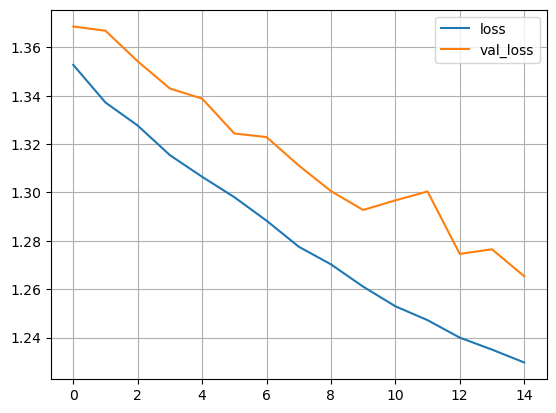

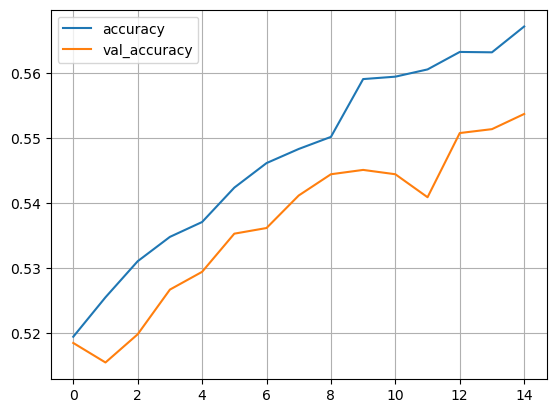

In [ ]:

train_logNew = modelNew.fit(X_train, y_train, epochs=15, batch_size=BATCH_SIZE, validation_split=.3, verbose=1, callbacks=[stopping, checkpoint, tensorboard_callback, cm_callback])
train_evalNew = modelNew.evaluate(X_train, y_train)
test_evalNew = modelNew.evaluate(X_test, y_test, verbose=2)
plot_loss(train_logNew)
plot_acc(train_logNew)

### Results and Notes

Looks pretty decent. One important factor to note is that the checkpoint only saves the weights, so the other details of the model are not carried through. In particular the optimizer is not saved, so we need to make sure we compile the model with the same optimizer that we used to train it. This will also mean that the model is not picking up exactly where it left off from in the training process, as the optimizer is also learning during the training process, and it is being reset. In general though, we should be able to pick up roughly from where we left off. 

The details vary a little depending on the exact optimizer choice, but the main thing that is "fogotten" is the learning rate and momentum of the optimizer. The optimizer will attempt to learn "how fast to move" and "how much to move" during the training process, in an effort to make the process more efficient and make convergance quicker. This information is not kept, so the new optimizer we create will start with default values that are not tailored to the model. This isn't really an issue, but the training process will likely take a bit longer than it otherwise would have. 

## Exercise

Implement a CNN model to classify the dataset. 

Try to:
<ul>
<li> Use a CNN model. </li>
<li> Use a checkpoint to save the best model. </li>
<li> Use tensorboard to monitor the training process. </li>
<li> Use some hyperparameter tuning to find the best model. </li>
</ul>

## Loading Pretrained Models and Transfer Learning

Our ability to save and recall models at will is powerful in allowing for a more managable training process, especially as the data becomes large and complex enough that training in one sitting is impractical. Loading models also leads us to another of the major benefits of using neural networks - we can load a model that has been trained elsewhere, usually with a massive training dataset and industrial level computing resources. 

Loading a model that was created elsewhere is not much more complex than loading one that we saved ourselves, in some ways it can even be easier, as several common models can be loaded directly from a function call, similar to an "empty" model or one of the built in keras or sklearn datasets.

### But it was Trained on a Different Dataset????

The models that we download were obviously trained on different datasets, not the ones that we actually want to use, so why bother with some premade model? One answer is that many of the tasks that we may want to do with a neural network are generic, for example there are several models that are trained to recognize common items in images or process text. A more targeted answer is that we can use the model as a starting point, and then fine tune it to our specific needs, which we will look at next time. In short, we can use the abilities of a highly trained model to extract information from images, then combine that with part of our own model that tailors the predictions to what we want.

### Transfer Learning

This entire area of learning is called <b>Transfer Learning</b> as we are transfering the learning done on one problem to some other problem. 

![Transfer Learning](images/transfer_learning.png "Transfer Learning")

The layered nature of neural networks lends itself well to this application, as does the large data and computing power requirements of making large and accurate models. This allows much more widespread use of highly accurate models as the ability to adapt a pretrained model is common while the ability to make a competitive one from scratch is rare. The first variety of transfer learning that we can look at is to replace the classifier, or the dense fully-connected part of a CNN that produces the actual classification. We can literally just slice off those layers and attach our own, then partially retrain the model of the only part that is capable of learning, the classifier we attached, learns to take the features extracted by the convolutional part and produce predictions into the classes we want. 

![Replace Layers](images/replace_layers.webp "Replace Layers")

### Example

![VGG16](images/vgg16.png "VGG16" )

We can load an external model and use it to make some predictions. There are several models that are pretrained and available to us to use. VGG16 is one developed to do image recognition, the name stands for "Visual Geometry Group" - a group of researchers at the University of Oxford who developed it, and ‘16’ implies that this architecture has 16 layers. The model got ~93% on the ImageNet test that we mentioned a couple of weeks ago. 

<b>Note:</b> this model, and some others that we can use, are not the sequential type that we are used to, they are functional, which basically means that they are more flexible and offer the ability to confgure models for more complex tasks. The impact that this has on us is that the syntx is a little different, but the ideas are the same. We can adapt the examples in the next 2 workbooks to use pretrained functional models, we don't need to delve into the details of their structure or setup to use them. 

In [ ]:

input_tensor = Input(shape=(32, 32, 3))
vgg = VGG16(include_top=False, weights='imagenet', input_tensor=input_tensor)

for layer in vgg.layers:
    layer.trainable = False

x = Flatten()(vgg.output)
x = Dense(128, activation="relu")(x)
x = Dropout(.2)(x)
prediction = Dense(10, activation="softmax")(x)

model = Model(inputs=vgg.input, outputs=prediction)

model.summary()

Model: "functional_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,781,642 (56.39 MB)

 Trainable params: 66,954 (261.54 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

#### Remix Edition of the Model That's Predictin'

What have we created here? The functional syntax above is basically chaining together the inputs and outputs of the layers, because one of the differences in these models is that they don't assume a layer-by-layer flow as the sequential ones do. 

<ul>
<li> The first part of the model is the VGG bit, it is frozen (non-trainable). 
<li> The next part is the Flatten layer, it takes in the input of vgg.output and outputs to x. 
<li> Next, a dense layer with 128 neurons and a relu activation, takes in that output of x, and outputs to x again. (This type of syntx is common if layers are just chained together.)
<li> Then there is a dropout for 20%, takes in that output of x, and outputs to x again.
<li> The last part is the prediction, it takes in x as an input, and outputs to our normal prediction - 5 neurons for 5 classes. (This one outputs logits.)
<li> The model takes in the vgg.input and outputs the final layer. Again, these models can have multiple in/out, so we have to specify. 
</ul>

Once the model is made, we can use it as normal to fit and predict, it will use the power of VGG combined with the specific classes that we provided in the final two layers. The part we added could theoretically be anything as long as it can deal with the data shape - since we are flattening, that is pretty flexible. 

Epoch 1/12
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 34s 26ms/step - accuracy: 0.4910 - loss: 1.6325 - precision: 0.7174 - recall: 0.2535 - val_accuracy: 0.5649 - val_loss: 1.2616 - val_precision: 0.7537 - val_recall: 0.3440
Epoch 2/12
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.5527 - loss: 1.2768 - precision: 0.7178 - recall: 0.3610 - val_accuracy: 0.5744 - val_loss: 1.2101 - val_precision: 0.7333 - val_recall: 0.4077
Epoch 3/12
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 34s 27ms/step - accuracy: 0.5815 - loss: 1.1976 - precision: 0.7342 - recall: 0.4130 - val_accuracy: 0.5865 - val_loss: 1.1778 - val_precision: 0.7344 - val_recall: 0.4239
Epoch 4/12
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 34s 27ms/step - accuracy: 0.5983 - loss: 1.1478 - precision: 0.7390 - recall: 0.4343 - val_accuracy: 0.5848 - val_loss: 1.1732 - val_precision: 0.7333 - val_recall: 0.4396
Epoch 5/12
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 34s 27ms/step - accuracy: 0.6046 - loss: 1.1325 - precision: 0.7452 - recall: 0.4446 - val_accuracy: 0

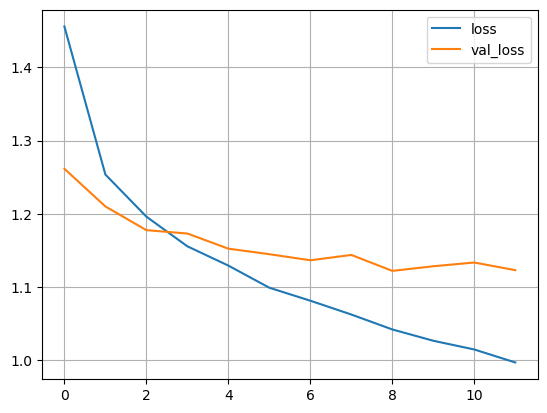

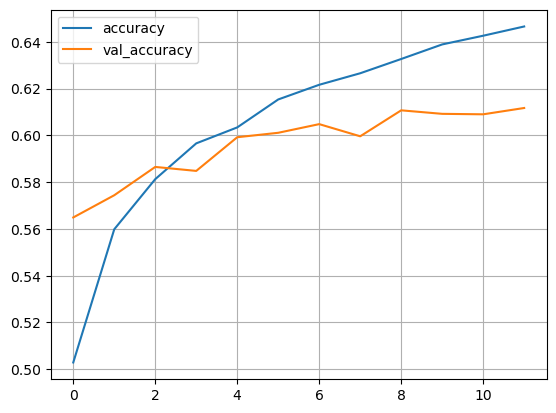

In [ ]:
model.compile(loss="categorical_crossentropy", 
            optimizer="adam", 
            metrics=metric_list)

log_dir = "logs/tb/VGG/vgg_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_images=True)

vgg_hist = model.fit(X_train, y_train,
            epochs=BASE_EPOCHS*4,
            verbose=1,
            callbacks=[stopping, tensorboard_callback],
            validation_split=.2)
plot_loss(vgg_hist)
plot_acc(vgg_hist)

In [ ]:
%reload_ext tensorboard
#%load_ext tensorboard
#%tensorboard --logdir=logs/tb/VGG

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Exercise

Try this VGG model on the other dataset. 

In [ ]:
print(img_train.shape, label_train.shape)

(60000, 28, 28) (60000,)
